In [14]:
import IsoSpecPy
import ms_peak_picker
import brainpy

%matplotlib inline

from matplotlib import pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

In [2]:
formula = "C24H26N6O5S1"
comp = brainpy.parse_formula(formula)

x = IsoSpecPy.IsoLayered(0.9999, formula)

In [3]:
x.sort_by_mass()

In [4]:
peaks = ms_peak_picker.PeakSet(
    [ms_peak_picker.FittedPeak(mass + brainpy.PROTON, prob * 100, prob, 0, 0, 0.01, prob, ) for mass, prob in zip(x.masses, x.probs)]
)
peaks.reindex()

In [ ]:
def reprofile_fwhm(peaks, fwhm, **kwargs):
    # Create a continuum spectrum at a fixed FWHM from `peaks`
    peaks = peaks.clone()
    for p in peaks:
        p.full_width_at_half_max = fwhm
    return ms_peak_picker.reprofile(peaks, **kwargs)

In [6]:
neutron_delta = {
    f"$^{{{(brainpy.periodic_table[elt].isotopes[1].neutrons)}}}${elt}": brainpy.periodic_table[
        elt
    ]
    .isotopes[1]
    .mass
    - brainpy.periodic_table[elt].isotopes[0].mass
    for elt in list(comp)
}

In [ ]:
def annotate_for_fwhm(fwhm, ax=None):
    # Draw the isotopic peaks
    ax = ms_peak_picker.plot.draw_peaklist(
        peaks, color="black", lw=0.5, pretty=False, ax=ax
    )

    # Use very, very high resolution to make sure we hit the peaks as pixel-
    # perfect as possible here because this is for pedantic humans.
    prof = reprofile_fwhm(peaks, fwhm, dx=0.00001)
    plt.plot(*prof)
    ms_peak_picker.plot.draw_peaklist(
        ms_peak_picker.pick_peaks(*prof),
        ax=ax,
        color="grey",
        lw=1,
        ls="--",
        pretty=False,
    )

    for elt, dif in neutron_delta.items():
        p = peaks.has_peak(peaks[0].mz + dif, 1e-6)
        if p:
            plt.text(p.mz, p.intensity + 0.1, elt, ha="center")

    # Begin overly-specific formatting of the ticks and the axes
    plt.gca()
    plt.xlim(512.16, 512.195)
    plt.ylim(0, 30)
    plt.xticks(
        [512.165, 512.17, 512.175, 512.18, 512.185, 512.19],
        [512.165, 512.17, 512.175, 512.18, 512.185, 512.19],
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    y = ax.yaxis.get_major_formatter()
    y.set_useOffset(False)
    y.set_scientific(False)

    # This calculation is an approximation since the the m/z being measured isn't
    # 500 m/z, but close enough for our purposes. Resolving power = (m_0 / (m_1 - m_0))
    # where m_0 = 500 and m_1 = (500 + fwhm).
    ax.text(512.18, 25, f"Resolving Power = {500 / fwhm:0.0f}", ha='center', size=12)
    return ax

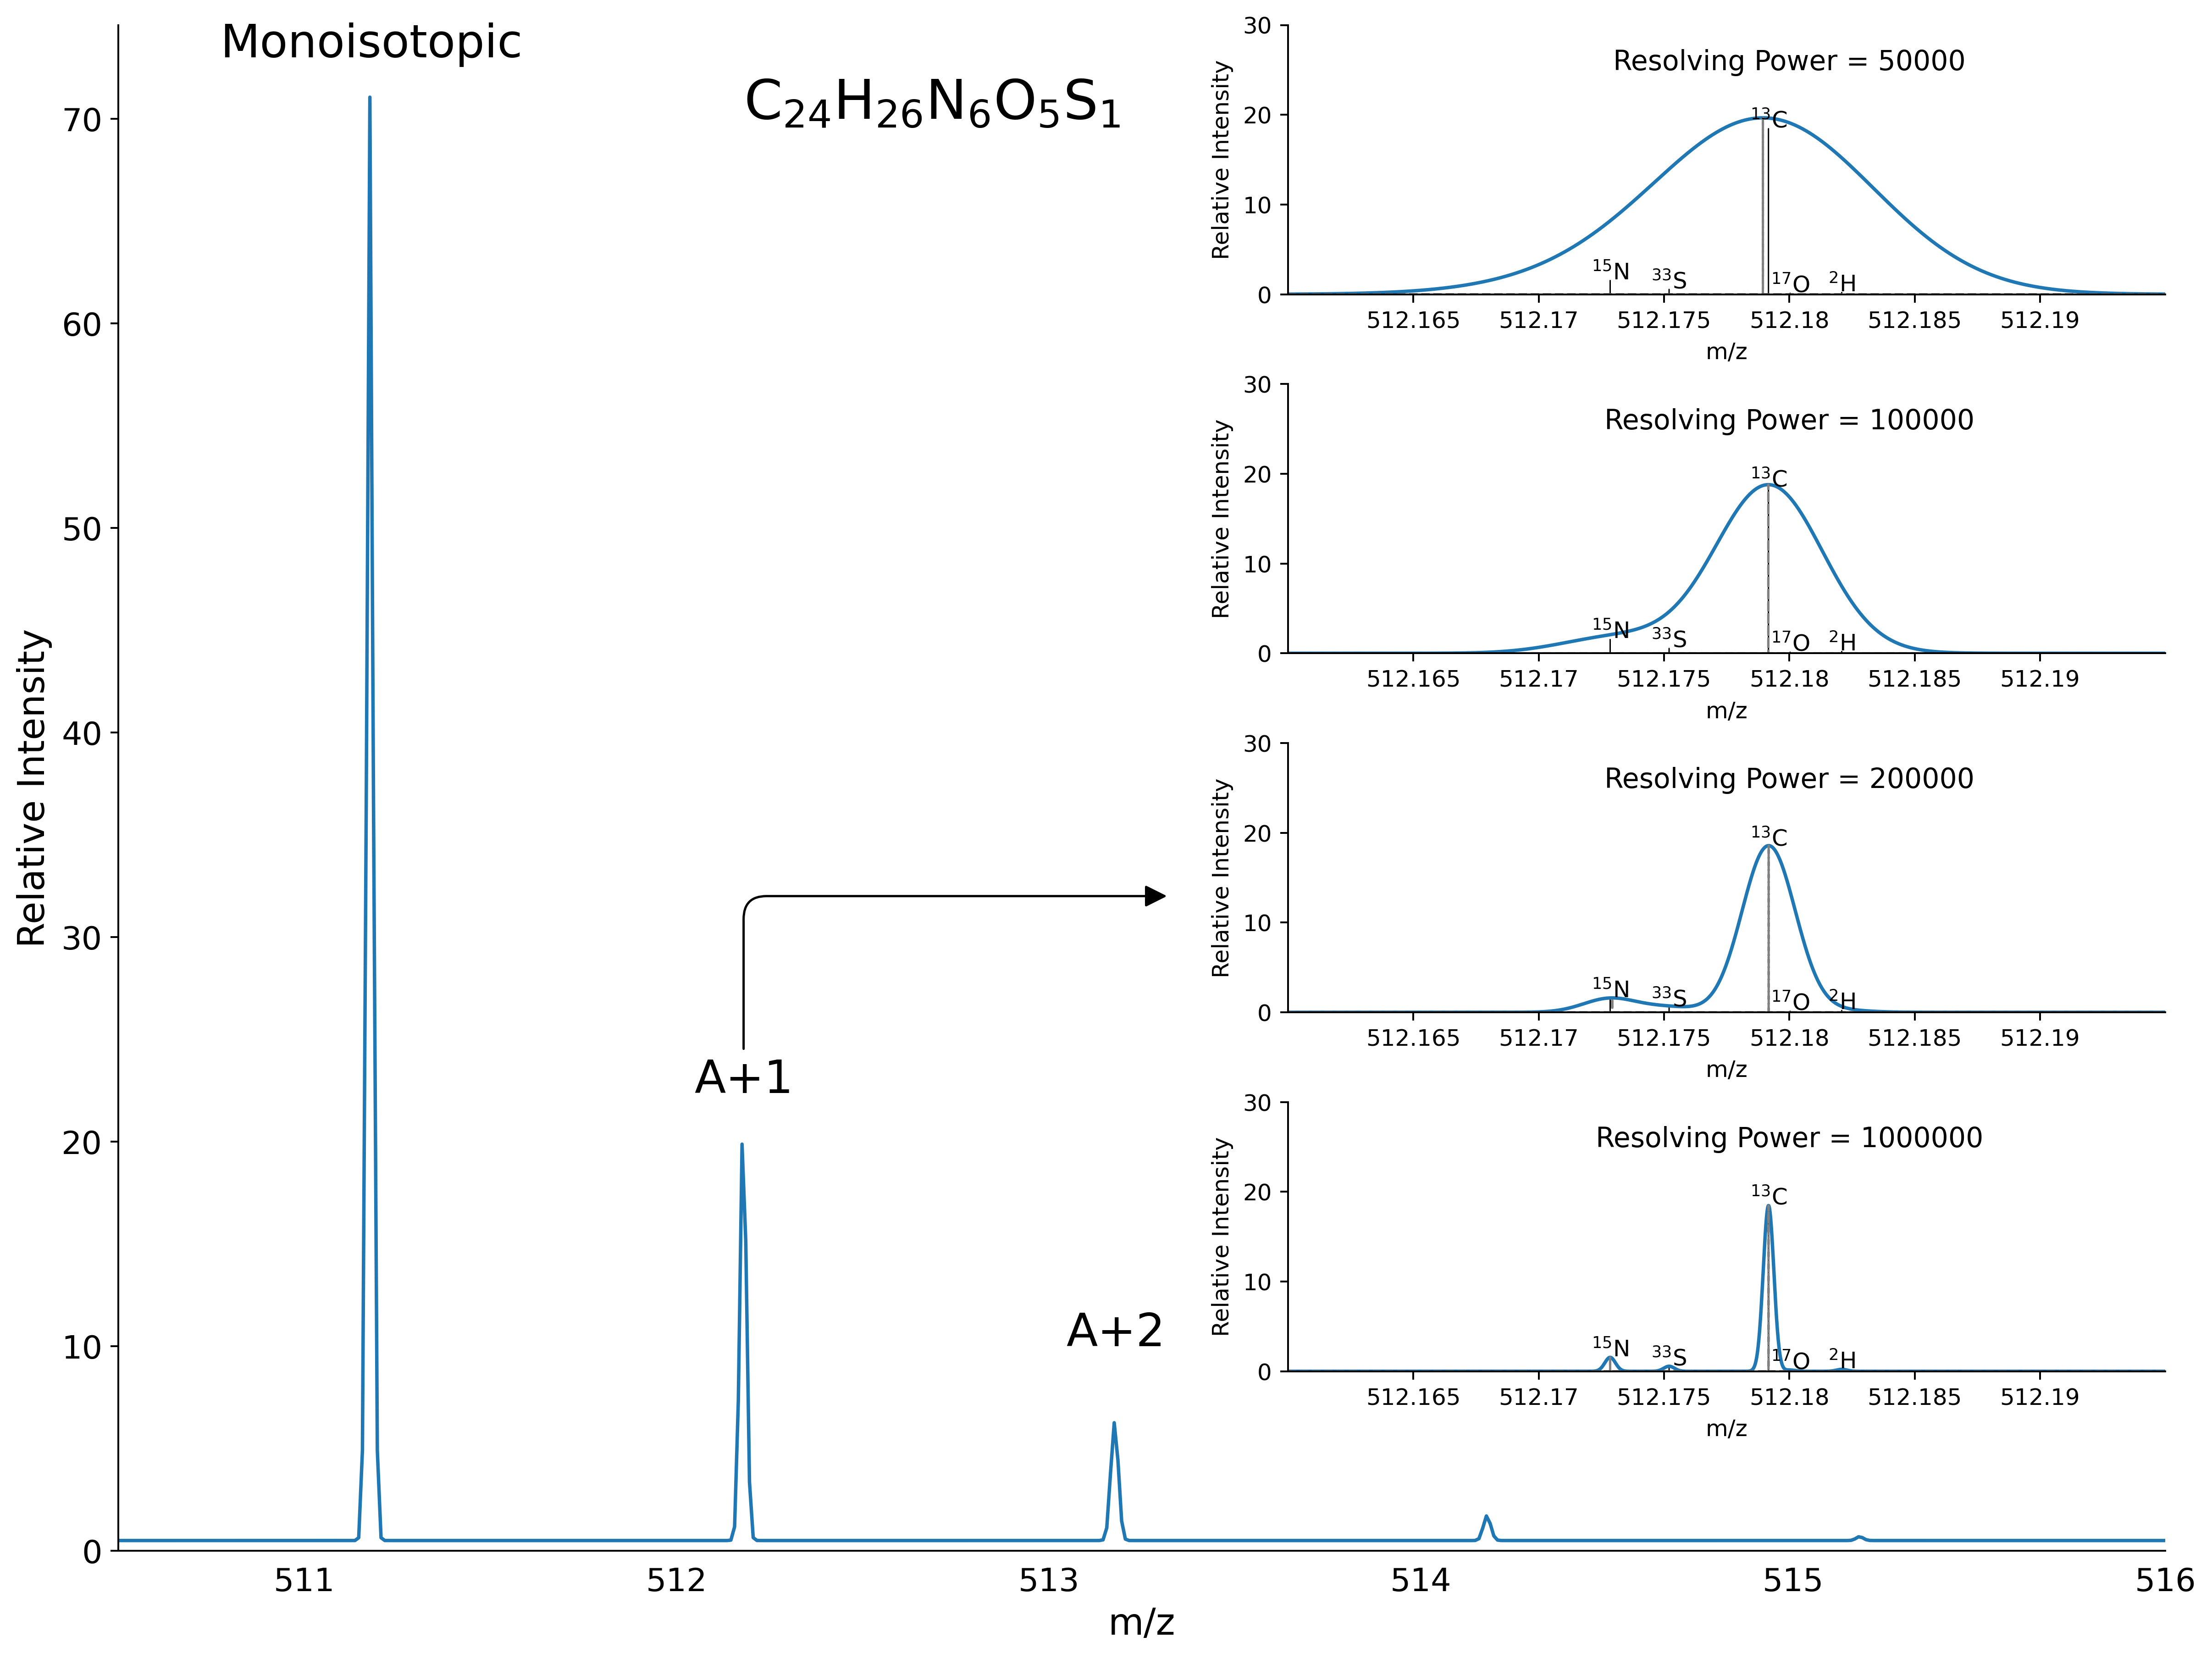

In [ ]:
# Set up main canvas and segmented inset windows

gs = plt.GridSpec(9, 11, wspace=1, hspace=1)
fig = plt.figure(figsize=(16, 12), dpi=180)
root_ax = fig.add_subplot(gs[:, :])

# Draw the primary isotopic pattern
a, b = reprofile_fwhm(peaks, 0.02)

ms_peak_picker.plot.draw_raw(a, b + 0.5, ax=root_ax)
root_ax.set_xlim(510.5, 516)
root_ax.yaxis.get_major_formatter().set_scientific(False)

# Label the primary isotopic peaks
root_ax.text(511.18, 73, "Monoisotopic", ha="center", size=20)

root_ax.text(512.18, 70, ''.join([f"{k}$_{{{v}}}$" for k, v in comp.items()]), size=24)

root_ax.annotate(
    "A+1",
    (512.33 + 1, 25 + 7),
    (512.18, 23),
    arrowprops=dict(
        color="black",
        arrowstyle="-|>",
        connectionstyle="angle,angleA=90,angleB=0,rad=50",

    ),
    size=20,
    ha="center",
    va="center",
)

root_ax.text(513.18, 10, "A+2", ha="center", size=20)

# Generate insets of varying resolution
ax = fig.add_subplot(gs[:2, -5:])
annotate_for_fwhm(0.01, ax=ax)

ax = fig.add_subplot(gs[2:4, -5:])
annotate_for_fwhm(0.005, ax=ax)

ax = fig.add_subplot(gs[4:6, -5:])
annotate_for_fwhm(0.0025, ax=ax)

ax = fig.add_subplot(gs[6:8, -5:])
annotate_for_fwhm(0.0005, ax=ax)

root_ax.set_xlabel(root_ax.get_xlabel(), size=16)
root_ax.set_ylabel("Relative Intensity", size=16)

for f in root_ax.get_xticklabels():
    f.set_size(14)

for f in root_ax.get_yticklabels():
    f.set_size(14)